/home/jcolen/envs/geopandas/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Grid shape (169, 150) Polygons shape (51, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 439
  Number of cells:
    line: 82
    triangle: 794
    vertex: 51


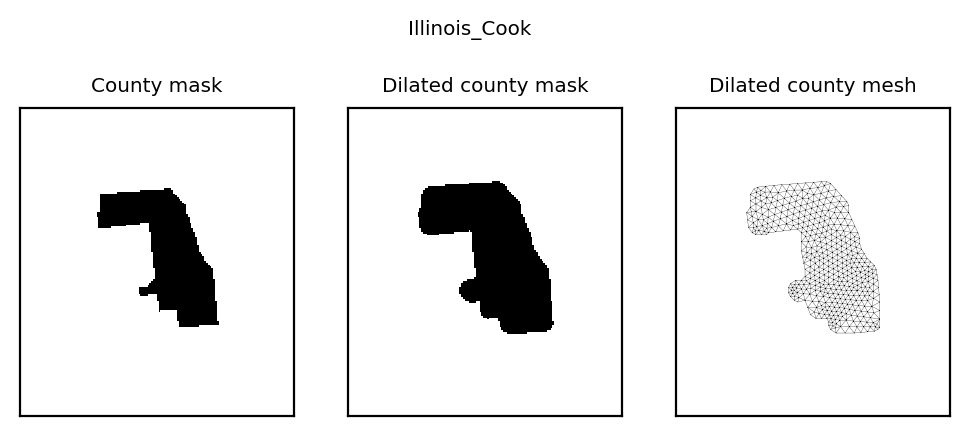

In [1]:
%matplotlib inline

import numpy as np
import h5py
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
np.set_printoptions(precision=2, suppress=False)

import cv2
import pygmsh
import os

plt.rcParams['font.size'] = 6
from skimage.morphology import erosion, dilation, disk

data_dir = '/home/jcolen/data/sociohydro/decennial/revision/'
spatial_scale = 1e3

def make_mesh(county, eps=1e-3, mesh_size=5, dilate=4, spatial_scale=1e3):
    '''
    Create a smooth mesh of the county by dilating the boundary
    county - name of the county in revision/gridded data folder
    eps - some parameter for cv2, keep fixed
    mesh_size - parameter for pygmsh, I find that 5 is good unless the county is tiny
    dilate - the size of the dilation structure (a disk)
    spatial_scale - rescaling to spatial units, which are currently meters. Set to 
        1e3 so that spatial units are km
    '''

    # Collect the county geometry data and grid points
    with h5py.File(f'{data_dir}/gridded/{county}.hdf5', 'r') as h5f:
        d = h5f['2010']
        mask = ~d['county_mask'][:].astype(bool)
        x_grid = d['x_grid'][:] / spatial_scale
        y_grid = d['y_grid'][:] / spatial_scale

    # Dilate the county mask
    mask_float = np.zeros(mask.shape, dtype=np.uint8)
    mask_float[mask] = 255
    structure = disk(dilate)
    mask_float = dilation(mask_float, structure)
    contours, _ = cv2.findContours(mask_float, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)

    # Create the contour for the county
    '''
    countours is a list of lists -- you can change the index below here to get 
        different contours to choose as the mesh.
    Choosing the largest contour is generally the right choice, but check each mesh to be sure
    '''
    idx = np.argmax([contours[i].squeeze().shape[0] for i in range(len(contours))])
    polygon = contours[idx].squeeze()
    
    #Simplify contour
    polygon = cv2.approxPolyDP(polygon, eps*cv2.arcLength(polygon, True), True)
    polygon = polygon.squeeze()
    
    # Get the grid points associated with each polygon vertex
    print('Grid shape', x_grid.shape, 'Polygons shape', polygon.shape)
    pos_x = x_grid[polygon[:, 1], polygon[:, 0]]
    pos_y = y_grid[polygon[:, 1], polygon[:, 0]]

    # Generate the mesh
    with pygmsh.geo.Geometry() as geom:
        geom.add_polygon(np.stack([pos_x, pos_y], axis=-1), mesh_size=mesh_size)
        mesh = geom.generate_mesh(dim=2, verbose=False)
    mesh.points = mesh.points[:, :2]
    save_path = f'{data_dir}/meshes/{county}.xml'

    # Save mesh and dilated mesh mask
    mesh.write(f'{data_dir}/meshes/{county}.xml')
    np.save(f'{data_dir}/meshes/{county}_dilated_mask.npy', mask_float.astype(bool))

    print(mesh)

    # Plot to make sure it looks right
    fig, ax = plt.subplots(1, 3, figsize=(6, 2.5), dpi=200, sharex=True, sharey=True)
    ax[0].pcolormesh(x_grid, y_grid, mask, cmap='Greys')
    ax[1].pcolormesh(x_grid, y_grid, mask_float, cmap='Greys')
    ax[2].triplot(mesh.points[:, 0], mesh.points[:, 1], mesh.cells[1].data,
                  color='black', linewidth=0.1)

    ax[0].set(xticks=[], yticks=[], aspect='equal', title='County mask')
    ax[1].set(xticks=[], yticks=[], aspect='equal', title='Dilated county mask')
    ax[2].set(xticks=[], yticks=[], aspect='equal', title='Dilated county mesh')
    
    fig.suptitle(county)

make_mesh('Illinois_Cook')

In [38]:
from pprint import pprint
counties = [c[:-5] for c in os.listdir('/home/jcolen/data/sociohydro/decennial/revision/gridded/')]
pprint(counties)
    

['Michigan_Oakland',
 'Ohio_Cuyahoga',
 'New York_Suffolk',
 'Georgia_Fulton',
 'New York_New York',
 'Utah_Salt Lake',
 'California_Orange',
 'Florida_Hillsborough',
 'California_San Diego',
 'Washington_King',
 'Michigan_Wayne',
 'California_Contra Costa',
 'Massachusetts_Middlesex',
 'California_Los Angeles',
 'Minnesota_Hennepin',
 'Illinois_Cook',
 'California_Sacramento',
 'Texas_Bexar',
 'Texas_Harris',
 'Pennsylvania_Philadelphia',
 'California_Santa Clara',
 'New York_Nassau',
 'Nevada_Clark',
 'California_Riverside',
 'Virginia_Fairfax',
 'New York_Queens',
 'California_Alameda',
 'New York_Kings',
 'Texas_Tarrant',
 'California_San Bernardino',
 'Arizona_Maricopa',
 'Florida_Palm Beach',
 'Florida_Broward',
 'Ohio_Franklin',
 'New York_Bronx',
 'Texas_Dallas',
 'Pennsylvania_Allegheny',
 'Florida_Orange']


Grid shape (457, 526) Polygons shape (49, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 2057
  Number of cells:
    line: 179
    triangle: 3933
    vertex: 49


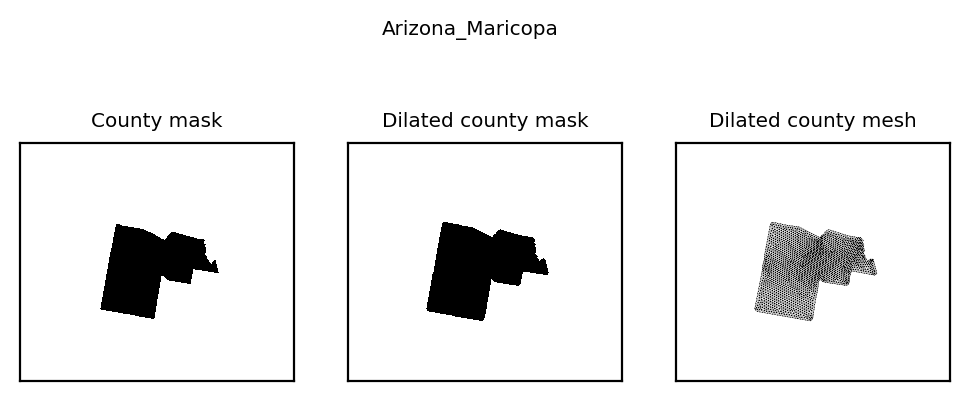

In [39]:
make_mesh('Arizona_Maricopa')

Grid shape (170, 178) Polygons shape (54, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 394
  Number of cells:
    line: 82
    triangle: 704
    vertex: 54


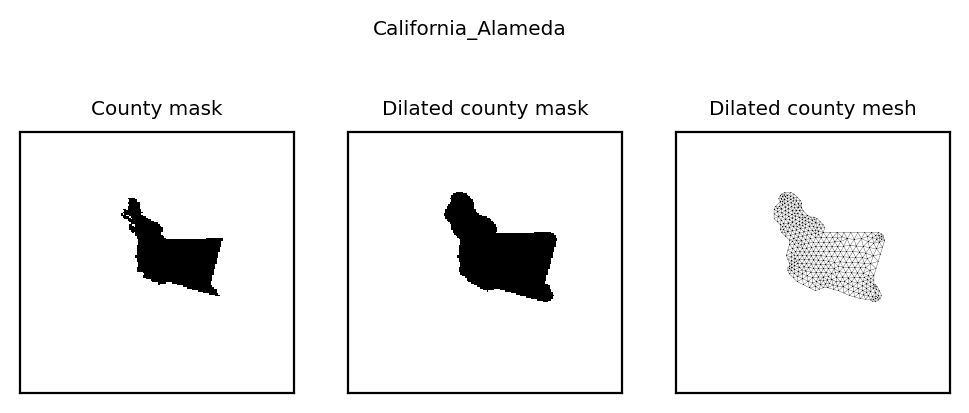

In [40]:
make_mesh('California_Alameda')

Grid shape (119, 181) Polygons shape (53, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 380
  Number of cells:
    line: 73
    triangle: 685
    vertex: 53


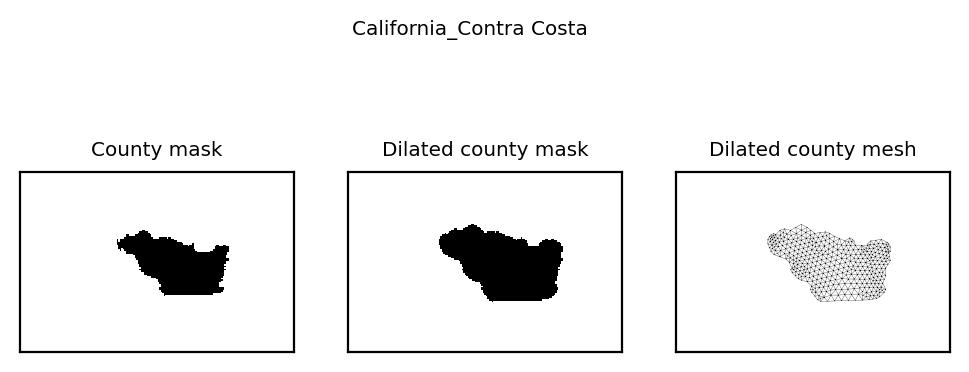

In [41]:
make_mesh('California_Contra Costa')

Grid shape (339, 342) Polygons shape (68, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 1196
  Number of cells:
    line: 130
    triangle: 2260
    vertex: 68


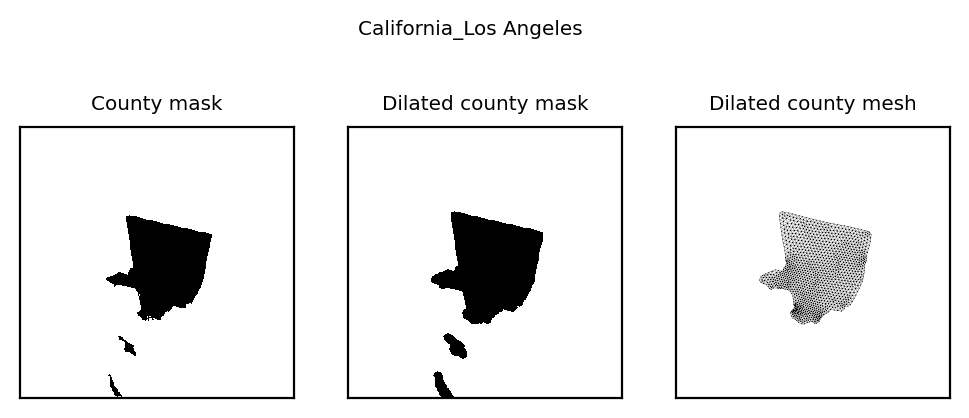

In [42]:
make_mesh('California_Los Angeles')

Grid shape (160, 142) Polygons shape (55, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 505
  Number of cells:
    line: 71
    triangle: 937
    vertex: 55


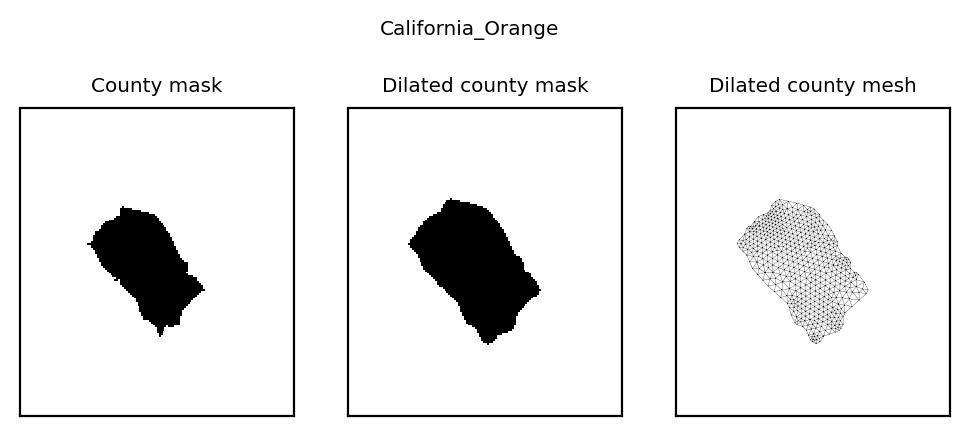

In [43]:
make_mesh('California_Orange')

Grid shape (304, 641) Polygons shape (62, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 1514
  Number of cells:
    line: 172
    triangle: 2854
    vertex: 62


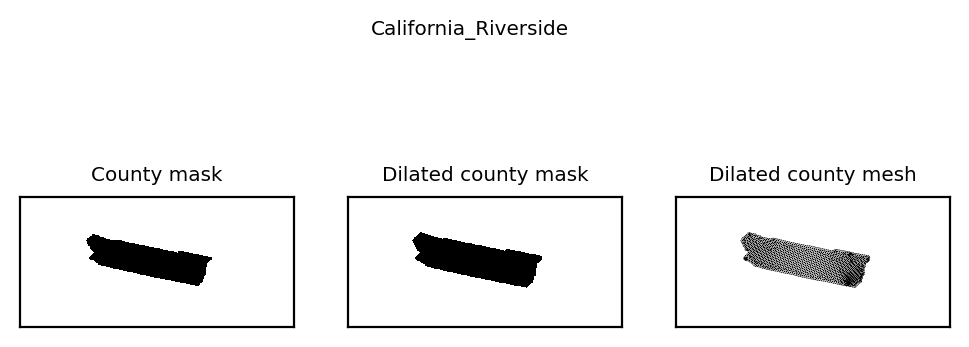

In [44]:
make_mesh('California_Riverside')

Grid shape (180, 192) Polygons shape (66, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 466
  Number of cells:
    line: 96
    triangle: 834
    vertex: 66


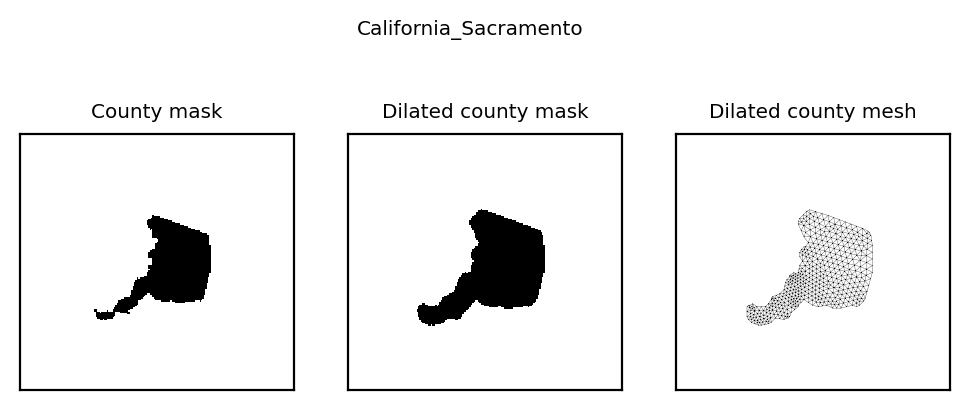

In [45]:
make_mesh('California_Sacramento')

Grid shape (625, 804) Polygons shape (52, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 3301
  Number of cells:
    line: 226
    triangle: 6374
    vertex: 52


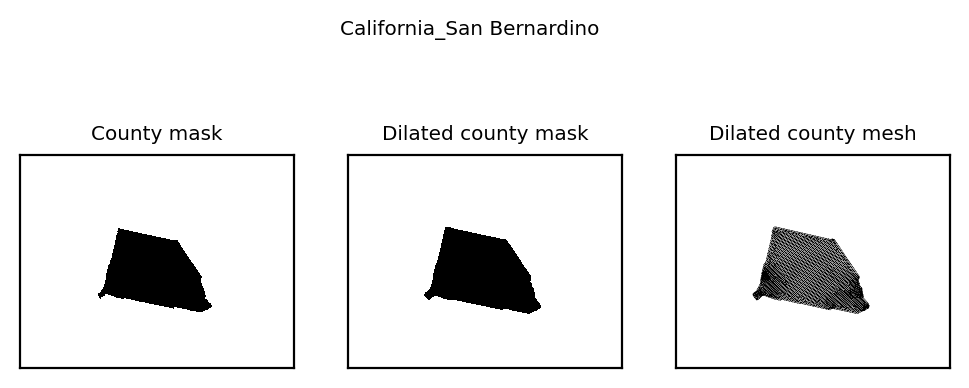

In [46]:
make_mesh('California_San Bernardino')

Grid shape (220, 334) Polygons shape (51, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 921
  Number of cells:
    line: 118
    triangle: 1722
    vertex: 51


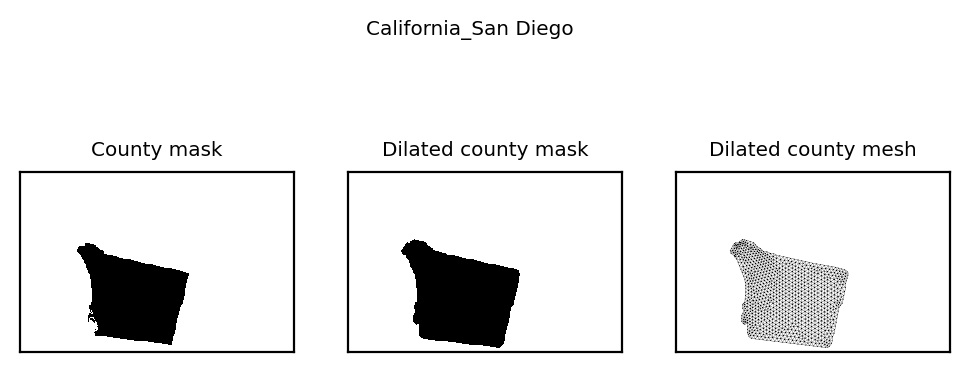

In [47]:
make_mesh('California_San Diego')

Grid shape (185, 187) Polygons shape (65, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 635
  Number of cells:
    line: 86
    triangle: 1182
    vertex: 65


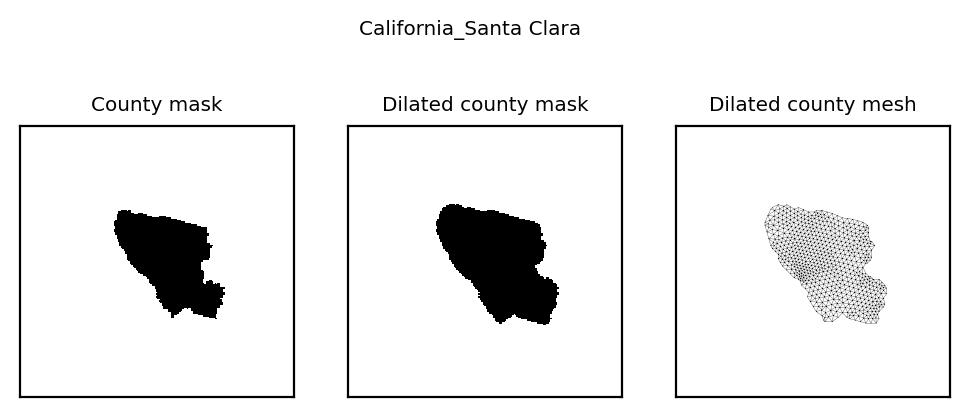

In [48]:
make_mesh('California_Santa Clara')

Grid shape (143, 163) Polygons shape (36, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 398
  Number of cells:
    line: 68
    triangle: 726
    vertex: 36


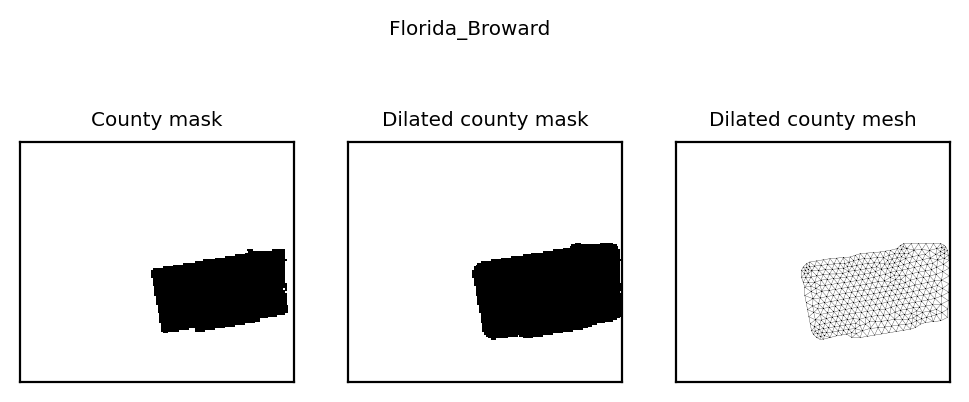

In [49]:
make_mesh('Florida_Broward')

Grid shape (183, 129) Polygons shape (44, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 377
  Number of cells:
    line: 79
    triangle: 673
    vertex: 44


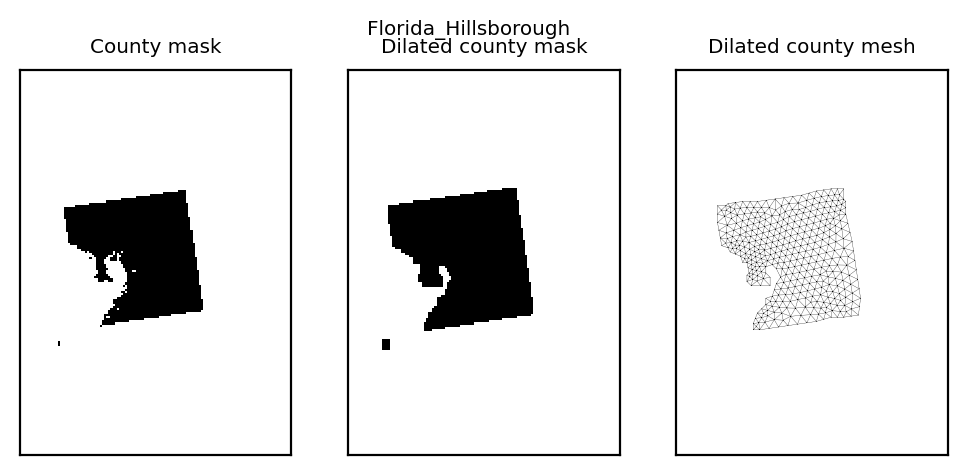

In [81]:
make_mesh('Florida_Hillsborough', dilate=2.5)

In [51]:
make_mesh('Florida_Miami-Dade')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/jcolen/data/sociohydro/decennial/revision//gridded/Florida_Miami-Dade.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Grid shape (188, 172) Polygons shape (32, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 524
  Number of cells:
    line: 80
    triangle: 966
    vertex: 32


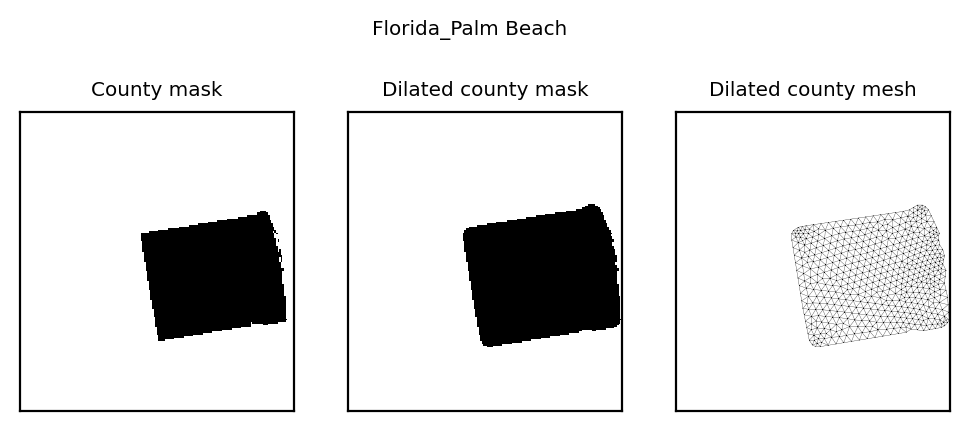

In [52]:
make_mesh('Florida_Palm Beach')

Grid shape (182, 144) Polygons shape (70, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 423
  Number of cells:
    line: 88
    triangle: 756
    vertex: 70


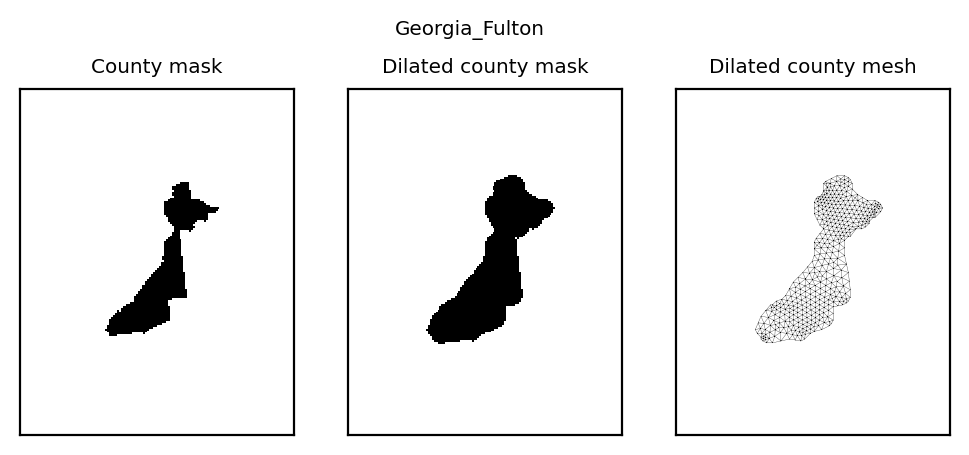

In [53]:
make_mesh('Georgia_Fulton')

Grid shape (169, 150) Polygons shape (51, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 439
  Number of cells:
    line: 82
    triangle: 794
    vertex: 51


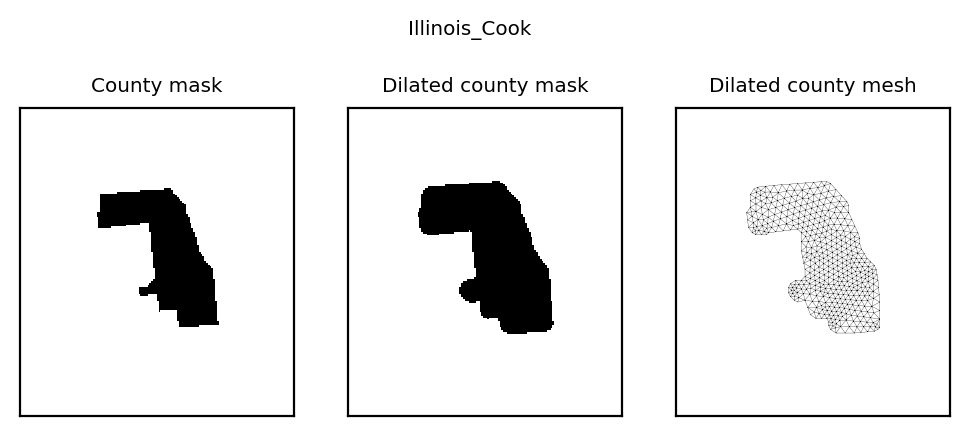

In [54]:
make_mesh('Illinois_Cook')

Grid shape (146, 167) Polygons shape (72, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 518
  Number of cells:
    line: 90
    triangle: 944
    vertex: 72


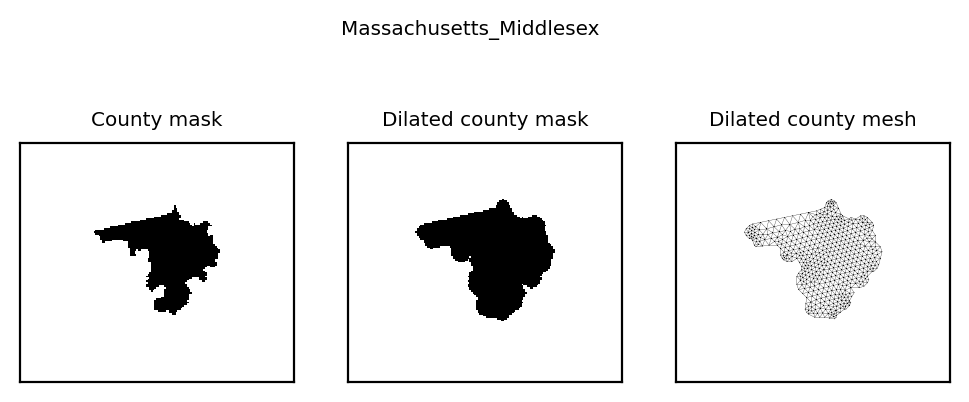

In [55]:
make_mesh('Massachusetts_Middlesex')

Grid shape (128, 126) Polygons shape (29, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 612
  Number of cells:
    line: 84
    triangle: 1138
    vertex: 29


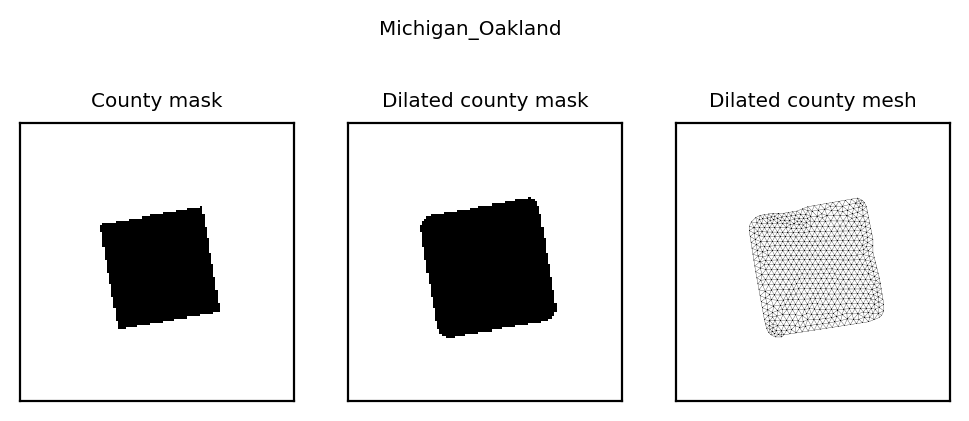

In [56]:
make_mesh('Michigan_Oakland', mesh_size=3)

Grid shape (110, 113) Polygons shape (44, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 556
  Number of cells:
    line: 90
    triangle: 1020
    vertex: 44


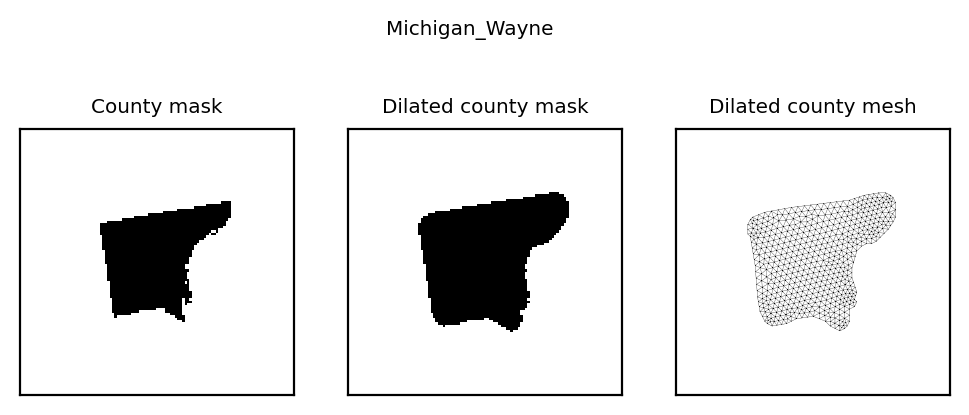

In [57]:
make_mesh('Michigan_Wayne', mesh_size=3)

Grid shape (119, 117) Polygons shape (43, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 359
  Number of cells:
    line: 60
    triangle: 656
    vertex: 43


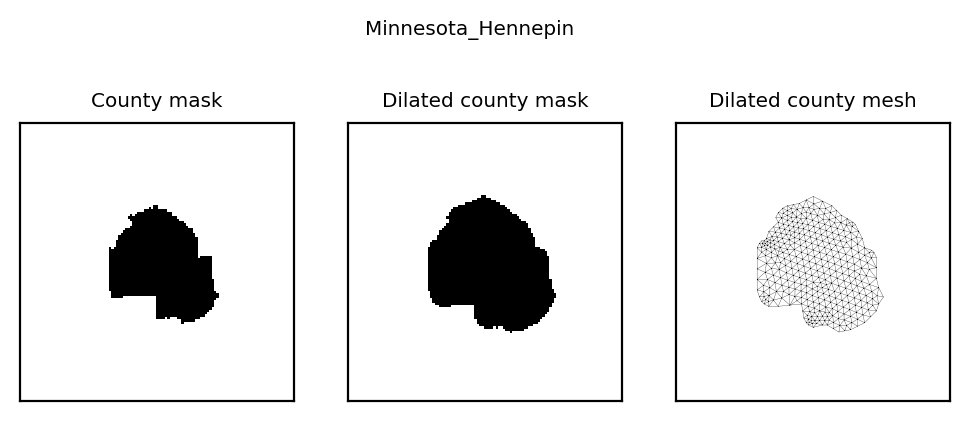

In [58]:
make_mesh('Minnesota_Hennepin')

Grid shape (477, 456) Polygons shape (57, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 1860
  Number of cells:
    line: 172
    triangle: 3546
    vertex: 57


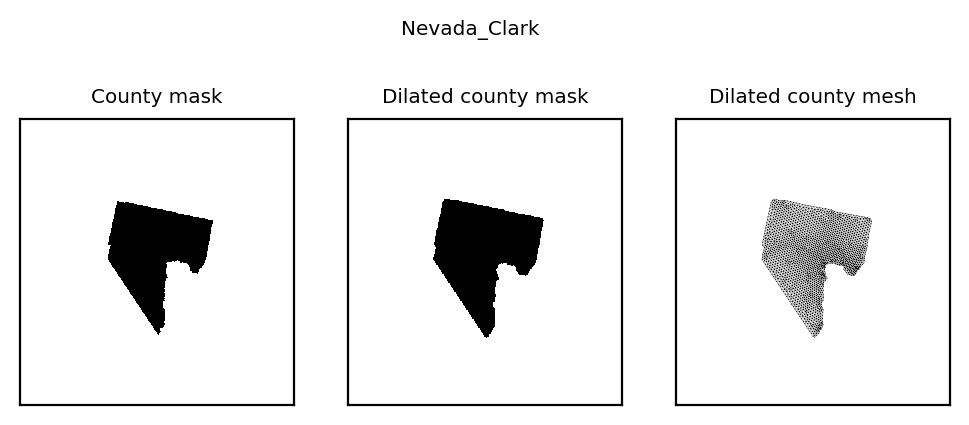

In [59]:
make_mesh('Nevada_Clark')

Grid shape (34, 33) Polygons shape (15, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 280
  Number of cells:
    line: 61
    triangle: 497
    vertex: 15


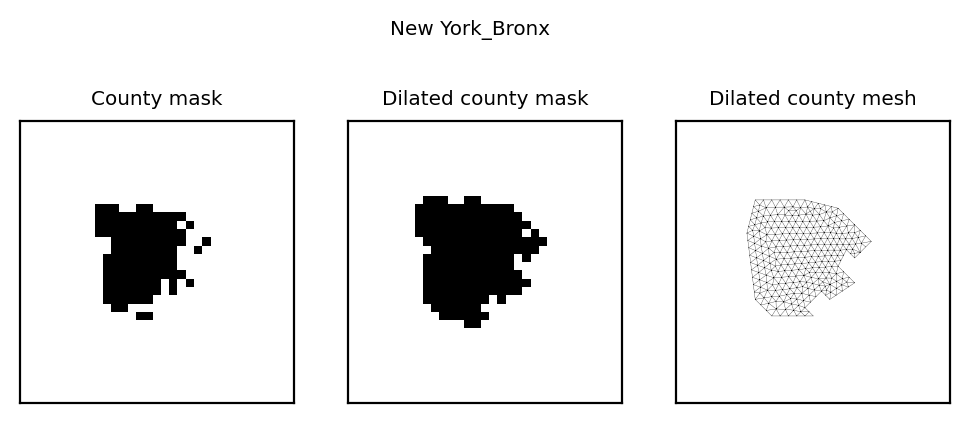

In [60]:
make_mesh('New York_Bronx', dilate=1, mesh_size=1)

Grid shape (40, 40) Polygons shape (20, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 426
  Number of cells:
    line: 76
    triangle: 774
    vertex: 20


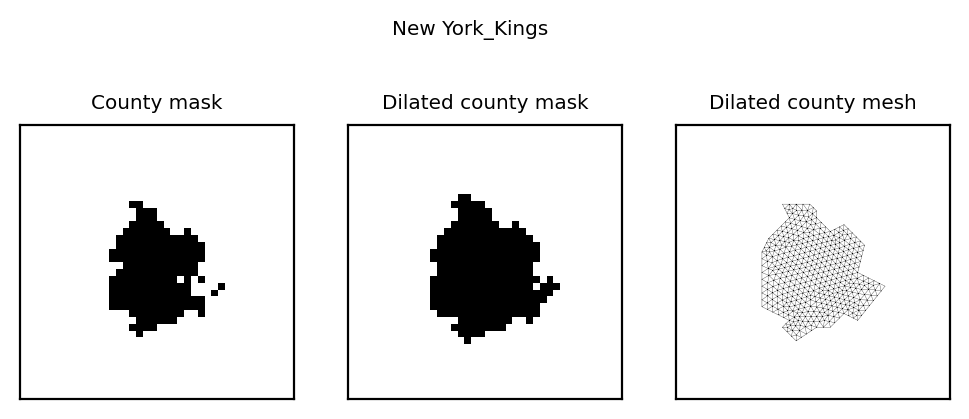

In [61]:
make_mesh('New York_Kings', dilate=1, mesh_size=1)

Grid shape (90, 73) Polygons shape (32, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 344
  Number of cells:
    line: 62
    triangle: 624
    vertex: 32


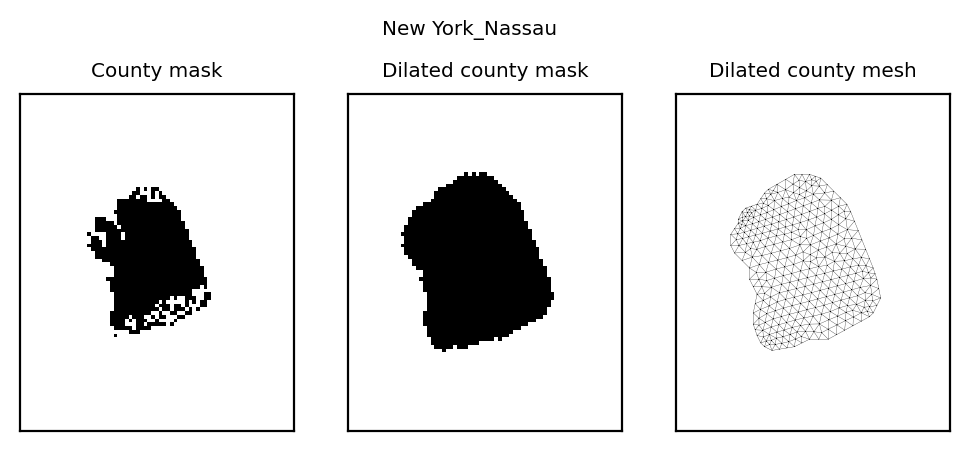

In [62]:
make_mesh('New York_Nassau', mesh_size=3)

Grid shape (50, 20) Polygons shape (14, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 474
  Number of cells:
    line: 109
    triangle: 837
    vertex: 14


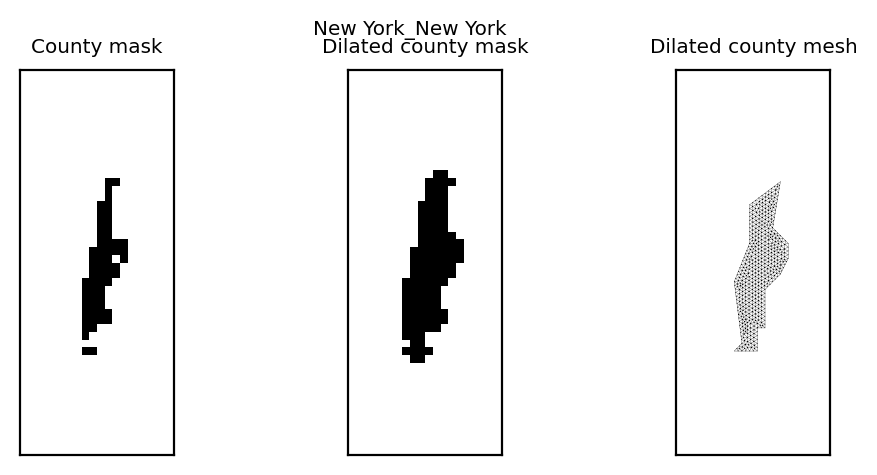

In [63]:
make_mesh('New York_New York', dilate=1, mesh_size=0.5)

Grid shape (74, 50) Polygons shape (36, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 397
  Number of cells:
    line: 78
    triangle: 714
    vertex: 36


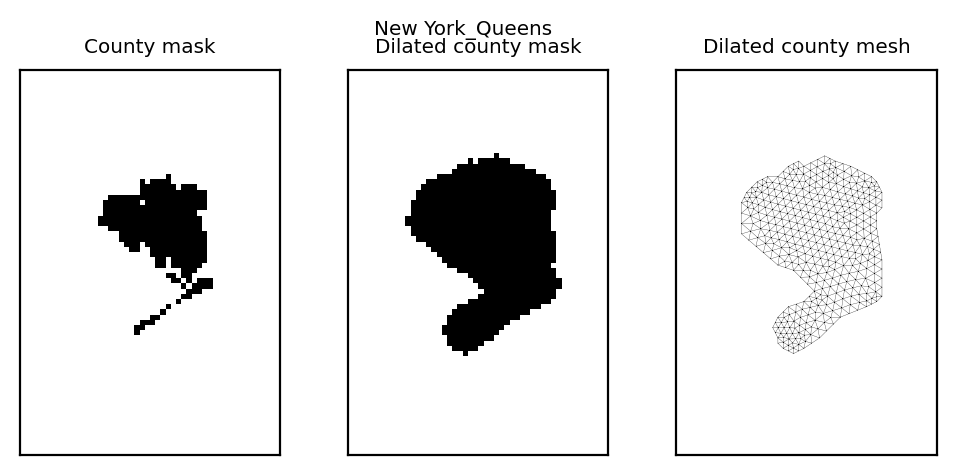

In [64]:
make_mesh('New York_Queens', mesh_size=2)

Grid shape (222, 260) Polygons shape (62, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 507
  Number of cells:
    line: 101
    triangle: 911
    vertex: 62


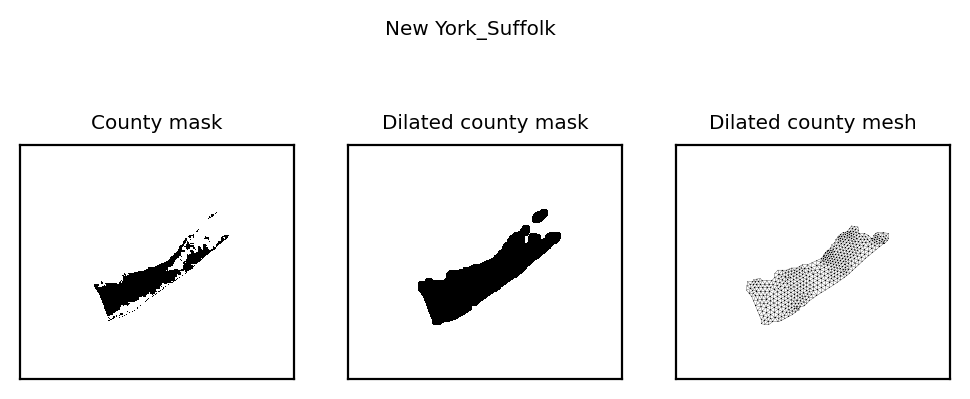

In [5]:
make_mesh('New York_Suffolk', dilate=4.5)

Grid shape (99, 112) Polygons shape (48, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 309
  Number of cells:
    line: 64
    triangle: 552
    vertex: 48


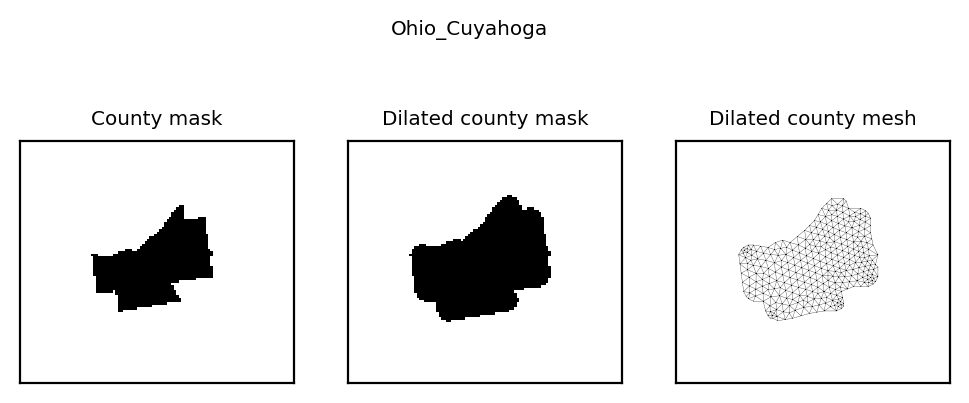

In [6]:
make_mesh('Ohio_Cuyahoga')

Grid shape (124, 123) Polygons shape (45, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 350
  Number of cells:
    line: 65
    triangle: 633
    vertex: 45


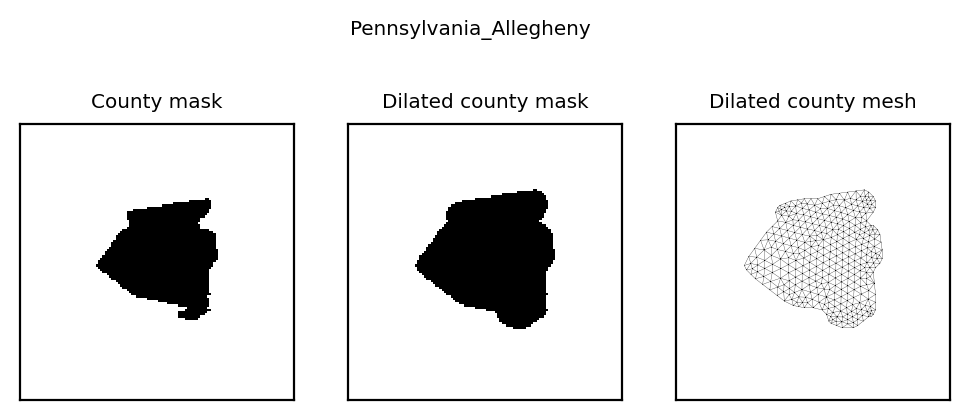

In [67]:
make_mesh('Pennsylvania_Allegheny')

Grid shape (76, 59) Polygons shape (30, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 448
  Number of cells:
    line: 76
    triangle: 818
    vertex: 30


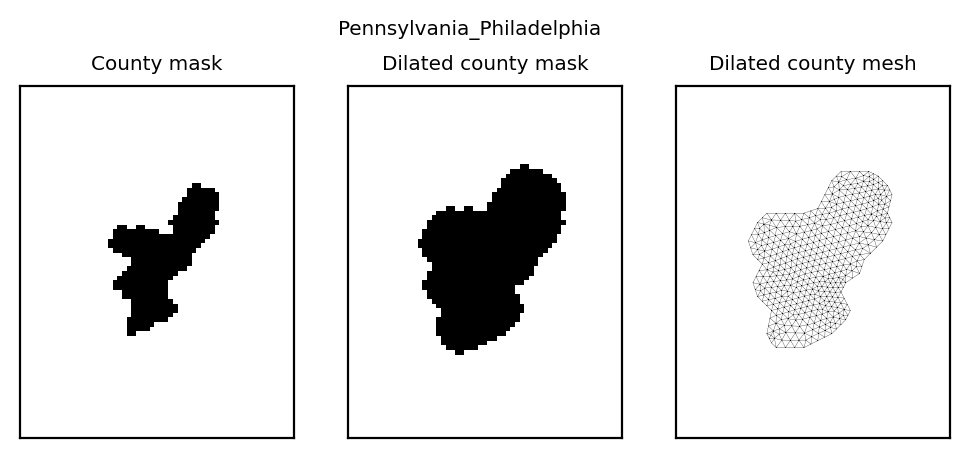

In [68]:
make_mesh('Pennsylvania_Philadelphia', dilate=4, eps=5e-4, mesh_size=2)

Grid shape (173, 160) Polygons shape (43, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 387
  Number of cells:
    line: 72
    triangle: 700
    vertex: 43


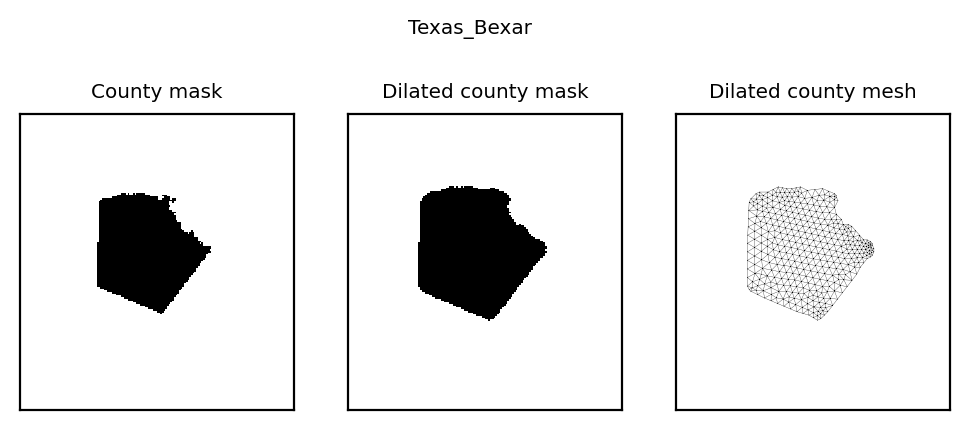

In [69]:
make_mesh('Texas_Bexar')

Grid shape (116, 123) Polygons shape (17, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 478
  Number of cells:
    line: 77
    triangle: 877
    vertex: 17


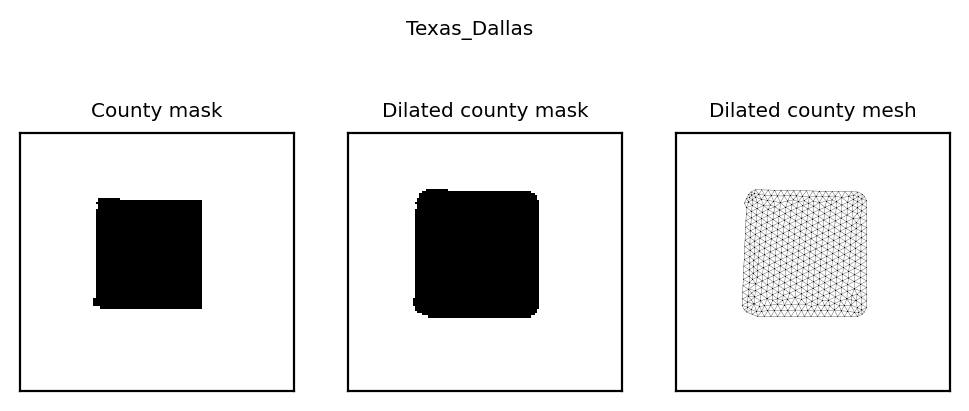

In [70]:
make_mesh('Texas_Dallas', mesh_size=3)

Grid shape (190, 235) Polygons shape (73, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 771
  Number of cells:
    line: 102
    triangle: 1438
    vertex: 73


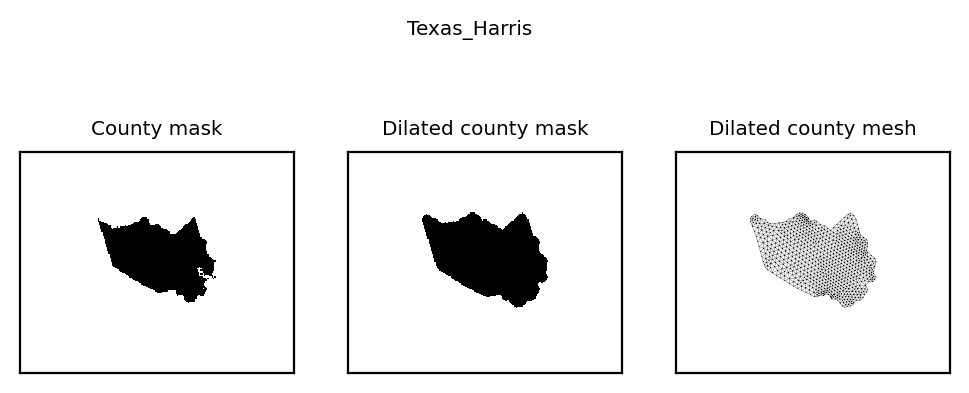

In [71]:
make_mesh('Texas_Harris')

Grid shape (134, 113) Polygons shape (18, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 311
  Number of cells:
    line: 63
    triangle: 557
    vertex: 18


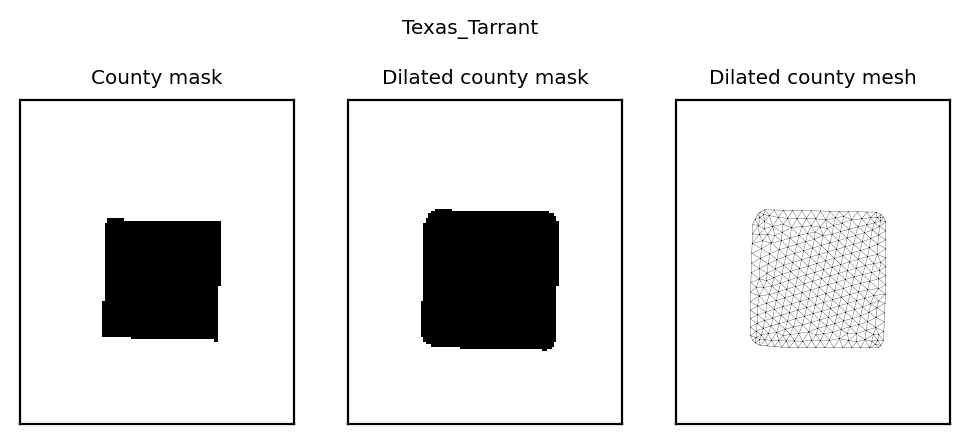

In [72]:
make_mesh('Texas_Tarrant', mesh_size=4)

Grid shape (150, 152) Polygons shape (49, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 418
  Number of cells:
    line: 68
    triangle: 766
    vertex: 49


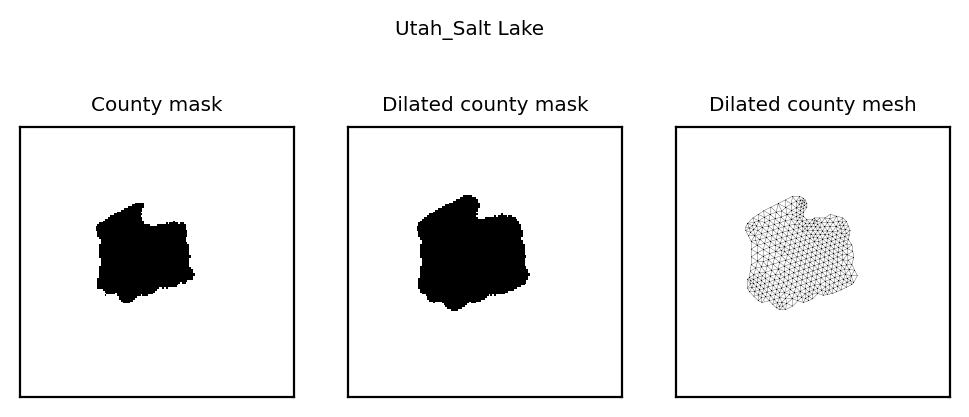

In [73]:
make_mesh('Utah_Salt Lake')

Grid shape (107, 104) Polygons shape (46, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 357
  Number of cells:
    line: 62
    triangle: 650
    vertex: 46


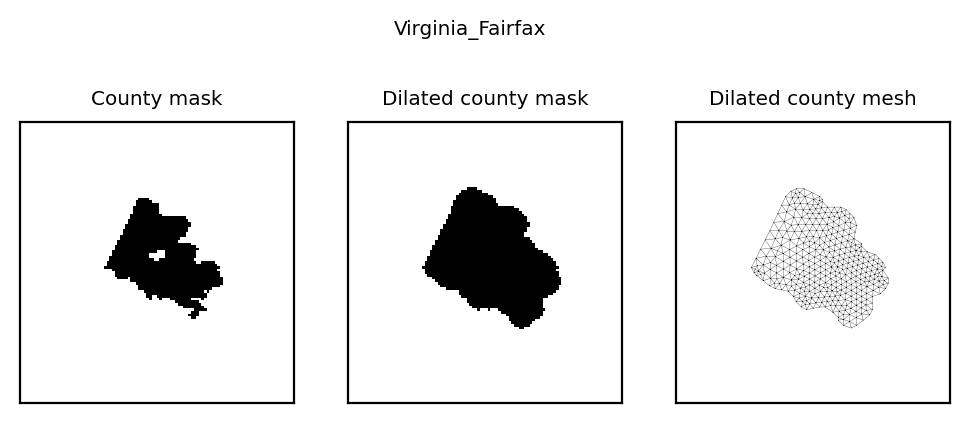

In [74]:
make_mesh('Virginia_Fairfax', mesh_size=4)

Grid shape (233, 276) Polygons shape (91, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 1061
  Number of cells:
    line: 120
    triangle: 2000
    vertex: 91


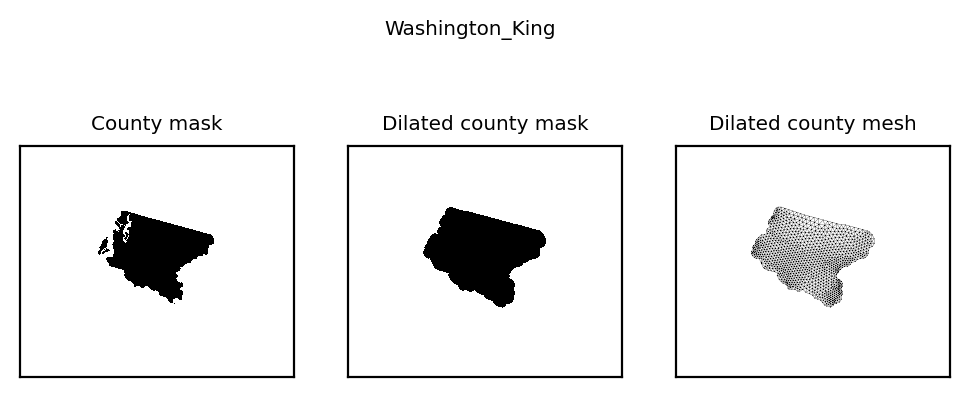

In [75]:
make_mesh('Washington_King')